# Visualizing Geospatial Data in Python

## By Paco Nathan posted Sun May 17, 2020 11:25 PM
## https://community.ibm.com/community/user/datascience/blogs/paco-nathan/2020/05/17/viz-geo-data-py     
 
Throughout the global pandemic, many people have spent lots of time viewing maps that visualize data. Important data. People who work in data science are probably seeing increased needs to work with geospatial data, especially for visualizations. There are increased needs to understand metrics about geographic regions, to analyze supply chain, make plans that take into account local conditions and rules, etc.

This article shows how to use two popular geospatial libraries in Python:

**geopandas:** extends Pandas to allow spatial operations on geometric types

**geoplot:** a high-level geospatial plotting library


The second library is especially helpful since it builds on top of several other popular geospatial libraries, to simplify the coding that’s typically required. Those include: cartopy, which in turn leverages Cython, NumPy, GEOS, Shapely, pyshp, PROJ, Six, and perhaps a few others such as mapclassify, depending on which features you need to use.

Note: all of this code is available in a Jupyter notebook at https://github.com/DerwenAI/ibm_dsc_articles/blob/master/2020_05/tutorial.ipynb


## Installation
You need two packages to run this tutorial: geopandas and geoplot
Installation should be quick. Just use the following command lines:

*#Run the following in terminal:*

conda create --name geoplot_compatible python=3.8

conda activate geoplot_compatible

conda install mamba -c conda-forge/label/mamba-alpha -c conda-forge

pip install Cython > 0.29.16

pip install descartes > 1.1.0

pip install imageio > 2.8.0

pip install jupyter > 1.0.0

pip install jupyterlab > 2.1.0

pip install matplotlib > 3.2.1

pip install shapely --no-binary shapely 

conda install -c anaconda git

pip install git+https://github.com/SciTools/cartopy.git --no-binary cartopy

pip install pysal --no-binary pysal

conda install --channel conda-forge cartopy

pip install geopandas

pip install geoplot

python -m ipykernel install --user --name=geoplot_compatible



To run this notebook in "geoplot_compatible", click "Kernel">"Change kernel" > "geoplot_compatible"

If you don't see "geoplot_compatible" as an option, refresh your browser page.

**Note:** if you run into problems with these installations, there are alternative approaches available. Some additional notes discuss how to build these dependencies on Linux  https://github.com/DerwenAI/ibm_dsc_articles/blob/master/2020_05/INSTALL.md

In [1]:
#To import the required packages for Python:

import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import pandas as pd
import pathlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np

%matplotlib inline

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

Note: if you run into problems with these installations, there are alternative approaches available. Some additional notes discuss how to build these dependencies on Linux  github.com/DerwenAI/ibm_dsc_articles/blob/master/2020_05/INSTALL.md

Terminology
Part of the learning curve for working with geospatial data is that there’s lots of special terminology used. Here’s a handy cheat-sheet for terms that you’re likely to encounter:

* **shapefile:** data file format used to represent items on a map
* **geometry:** a vector (generally a column in a dataframe) used to represent points, polygons, and other geometric shapes or locations, usually represented as well-known text (WKT)
* **polygon:** an area
* **point:** a specific location
* **basemap:** the background setting for a map, such as county borders in California
* **projection:** since the Earth is a 3D spheroid, chose a method for how an area gets flattened into 2D map, using some coordinate reference system (CRS)
* **colormap:** choice of a color palette for rendering data, selected with the cmap parameter
* **overplotting:** stacking several different plots on top of one another
* **choropleth:** using different hues to color polygons, as a way to represent data levels
* **kernel density estimation:** a data smoothing technique (KDE) that creates contours of shading to represent data levels
* **cartogram:** warping the relative area of polygons to represent data levels
* **quantiles:** binning data values into a specified number of equal-sized groups
* **voronoi diagram:** dividing an area into polygons such that each polygon contains exactly one generating point and every point in a given polygon is closer to its generating point than to any other; also called a Dirichlet tessellation

Okay, with those terms defined here for reference … let’s go!

### Load Some Data
We need to get some data to use for these examples. While geoplot includes plenty of sample datasets in the geojson format, it helps to know how to load your own data.

First, let’s get a shapefile from the US Census Bureau TIGER database to visualize state boundaries, which we’ll place into a maps subdirectory:

In [4]:
usa = gpd.read_file("./maps/cb_2018_us_state_20m.shp")
usa.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


Notice the geometry column above, which specifies polygon shapes.

Now we'll load the US Census data as a pandas dataframe and view a portion of it:

In [5]:
state_pop = pd.read_csv("./maps/nst-est2018-alldata.csv")
state_pop.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,DEATHS2010,DEATHS2011,DEATHS2012,DEATHS2013,DEATHS2014,DEATHS2015,DEATHS2016,DEATHS2017,DEATHS2018,NATURALINC2010,NATURALINC2011,NATURALINC2012,NATURALINC2013,NATURALINC2014,NATURALINC2015,NATURALINC2016,NATURALINC2017,NATURALINC2018,INTERNATIONALMIG2010,INTERNATIONALMIG2011,INTERNATIONALMIG2012,INTERNATIONALMIG2013,INTERNATIONALMIG2014,INTERNATIONALMIG2015,INTERNATIONALMIG2016,INTERNATIONALMIG2017,INTERNATIONALMIG2018,DOMESTICMIG2010,DOMESTICMIG2011,DOMESTICMIG2012,DOMESTICMIG2013,DOMESTICMIG2014,DOMESTICMIG2015,DOMESTICMIG2016,DOMESTICMIG2017,DOMESTICMIG2018,NETMIG2010,NETMIG2011,NETMIG2012,NETMIG2013,NETMIG2014,NETMIG2015,NETMIG2016,NETMIG2017,NETMIG2018,RESIDUAL2010,RESIDUAL2011,RESIDUAL2012,RESIDUAL2013,RESIDUAL2014,RESIDUAL2015,RESIDUAL2016,RESIDUAL2017,RESIDUAL2018,RBIRTH2011,RBIRTH2012,RBIRTH2013,RBIRTH2014,RBIRTH2015,RBIRTH2016,RBIRTH2017,RBIRTH2018,RDEATH2011,RDEATH2012,RDEATH2013,RDEATH2014,RDEATH2015,RDEATH2016,RDEATH2017,RDEATH2018,RNATURALINC2011,RNATURALINC2012,RNATURALINC2013,RNATURALINC2014,RNATURALINC2015,RNATURALINC2016,RNATURALINC2017,RNATURALINC2018,RINTERNATIONALMIG2011,RINTERNATIONALMIG2012,RINTERNATIONALMIG2013,RINTERNATIONALMIG2014,RINTERNATIONALMIG2015,RINTERNATIONALMIG2016,RINTERNATIONALMIG2017,RINTERNATIONALMIG2018,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RDOMESTICMIG2016,RDOMESTICMIG2017,RDOMESTICMIG2018,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018
0,10,0,0,0,United States,308745538,308758105,309326085,311580009,313874218,316057727,318386421,320742673,323071342,325147121,327167434,567980,2253924,2294209,2183509,2328694,2356252,2328669,2075779,2020313,987836,3973485,3936976,3940576,3963195,3992376,3962654,3901982,3855500,598691,2512442,2501531,2608019,2582448,2699826,2703215,2779436,2814013,389145,1461043,1435445,1332557,1380747,1292550,1259439,1122546,1041487,178835,792881,858764,850952,947947,1063702,1069230,953233,978826,0,0,0,0,0,0,0,0,0,178835,792881,858764,850952,947947,1063702,1069230,953233,978826,0,0,0,0,0,0,0,0,0,12.798989,12.589174,12.511117,12.493440,12.493176,12.309934,12.039096,11.820984,8.092824,7.999086,8.280320,8.140821,8.448453,8.397503,8.575615,8.627779,4.706164,4.590088,4.230797,4.352620,4.044723,3.912431,3.463480,3.193205,2.553948,2.746049,2.701727,2.988276,3.328598,3.321549,2.941086,3.001086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.553948,2.746049,2.701727,2.988276,3.328598,3.321549,2.941086,3.001086
1,20,1,0,0,Northeast Region,55317240,55318430,55380645,55600532,55776729,55907823,56015864,56047587,56058789,56072676,56111079,62215,219887,176197,131094,108041,31723,11202,13887,38403,163454,646265,637904,635741,632433,634515,628039,616552,609336,110848,470816,460985,480032,470196,488881,480331,501022,506909,52606,175449,176919,155709,162237,145634,147708,115530,102427,45723,206686,207584,194103,222685,227275,236718,215872,229700,-32918,-159789,-205314,-216273,-274391,-339996,-372953,-316879,-292928,12805,46897,2270,-22170,-51706,-112721,-136235,-101007,-63228,-3196,-2459,-2992,-2445,-2490,-1190,-271,-636,-796,11.646389,11.454834,11.384583,11.301147,11.324210,11.204340,10.996949,10.863177,8.484610,8.277902,8.596211,8.402082,8.725075,8.569200,8.936332,9.037120,3.161779,3.176932,2.788371,2.899065,2.599135,2.635140,2.060617,1.826058,3.724704,3.727583,3.475915,3.979229,4.056184,4.223096,3.850338,4.095067,-2.879569,-3.686821,-3.872926,-4.903180,-6.067920,-6.653556,-5.651919,-5.222289,0.845134,0.040762,-0.397011,-0.923951,-2.011735,-2.430459,

Next we *merge* the shapefile with population data, joining on the state names:

In [6]:
pop_states = usa.merge(state_pop, left_on="NAME", right_on="NAME")
pop_states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,SUMLEV,REGION,DIVISION,STATE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,DEATHS2010,DEATHS2011,DEATHS2012,DEATHS2013,DEATHS2014,DEATHS2015,DEATHS2016,DEATHS2017,DEATHS2018,NATURALINC2010,NATURALINC2011,NATURALINC2012,NATURALINC2013,NATURALINC2014,NATURALINC2015,NATURALINC2016,NATURALINC2017,NATURALINC2018,INTERNATIONALMIG2010,INTERNATIONALMIG2011,INTERNATIONALMIG2012,INTERNATIONALMIG2013,INTERNATIONALMIG2014,INTERNATIONALMIG2015,INTERNATIONALMIG2016,INTERNATIONALMIG2017,INTERNATIONALMIG2018,DOMESTICMIG2010,DOMESTICMIG2011,DOMESTICMIG2012,DOMESTICMIG2013,DOMESTICMIG2014,DOMESTICMIG2015,DOMESTICMIG2016,DOMESTICMIG2017,DOMESTICMIG2018,NETMIG2010,NETMIG2011,NETMIG2012,NETMIG2013,NETMIG2014,NETMIG2015,NETMIG2016,NETMIG2017,NETMIG2018,RESIDUAL2010,RESIDUAL2011,RESIDUAL2012,RESIDUAL2013,RESIDUAL2014,RESIDUAL2015,RESIDUAL2016,RESIDUAL2017,RESIDUAL2018,RBIRTH2011,RBIRTH2012,RBIRTH2013,RBIRTH2014,RBIRTH2015,RBIRTH2016,RBIRTH2017,RBIRTH2018,RDEATH2011,RDEATH2012,RDEATH2013,RDEATH2014,RDEATH2015,RDEATH2016,RDEATH2017,RDEATH2018,RNATURALINC2011,RNATURALINC2012,RNATURALINC2013,RNATURALINC2014,RNATURALINC2015,RNATURALINC2016,RNATURALINC2017,RNATURALINC2018,RINTERNATIONALMIG2011,RINTERNATIONALMIG2012,RINTERNATIONALMIG2013,RINTERNATIONALMIG2014,RINTERNATIONALMIG2015,RINTERNATIONALMIG2016,RINTERNATIONALMIG2017,RINTERNATIONALMIG2018,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RDOMESTICMIG2016,RDOMESTICMIG2017,RDOMESTICMIG2018,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",40,3,5,24,5773552,5773798,5788642,5838991,5887072,5923704,5958165,5986717,6004692,6024891,6042718,14844,50349,48081,36632,34461,28552,17975,20199,17827,18454,73542,72720,72362,72756,74158,73387,72138,71029,10628,43674,43461,45736,44735,47160,47239,50555,51184,7826,29868,29259,26626,28021,26998,26148,21583,19845,6590,20726,25760,21406,23397,27566,21569,22756,22575,841,208,-6323,-10919,-16504,-25680,-29676,-24011,-24518,7431,20934,19437,10487,6893,1886,-8107,-1255,-1943,-413,-453,-615,-481,-453,-332,-66,-129,-75,12.649522,12.403140,12.253556,12.246558,12.416699,12.239929,11.993433,11.771843,7.512105,7.412718,7.744792,7.529960,7.896269,7.878807,8.405113,8.482873,5.137417,4.990422,4.508764,4.716598,4.520430,4.361122,3.588321,3.288970,3.564956,4.393632,3.624825,3.938269,4.615533,3.597409,3.783340,3.741421,0.035777,-1.078452,-1.848989,-2.778014,-4.299749,-4.949543,-3.991992,-4.063440,3.600733,3.315179,1.775836,1.160255,0.315784,-1.352135,-0.208652,-0.322019
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",40,2,4,19,3046355,3046872,3050767,3066054,3076097,3093078,3109504,3121460,3131785,3143637,3156145,3895,15287,10043,16981,16426,11956,10325,11852,12508,9966,37852,38478,38805,39460,39694,39428,38892,38417,6871,28210,28048,29139,28925,29808,29189,28817,28803,3095,9642,10430,9666,10535,9886,10239,10075,9614,1454,6180,4068,6973,6862,5492,5622,5809,5828,-553,-541,-4438,306,-891,-3304,-5508,-4010,-2886,901,5639,-370,7279,5971,2188,114,1799,2942,-101,6,-17,36,-80,-118,-28,-22,-48,12.376363,12.529161,12.580288,12.723733,12.740886,12.610413,12.395023,12.196295,9.223745,9.132957,9.446644,9.326761,9.567701,9.335633,9.184084,9.144126,3.152618,3.396204,3.133644,3.396972,3.173185,3.274780,3.210939,3.052169,2.020657,1.324617,2.260594,2.212627,1.762809,1.798106,1.851350,1.850223,-0.176889,-1.445096,0.099203,-0.287300

Great, now that data is ready to plot a shape. We'll specify "California" by name:

<AxesSubplot:>

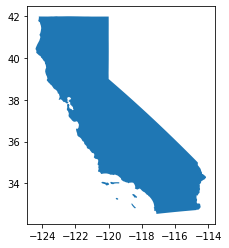

In [7]:
pop_states[pop_states.NAME=="California"].plot()

Alternatively, we can create a GeoDataFrame (a dataframe with geospatial data) by loading one of the sample datasets from geoplot, in this case the polygones for state boundaries. Search around in "gplt.datasets" to learn more about baselayers available for plotting without download:

In [8]:
path = gplt.datasets.get_path("contiguous_usa")
contiguous_usa = gpd.read_file(path)
contiguous_usa.head()

,state,adm1_code,population,geometry
0,Minnesota,USA-3514,5303925,"POLYGON ((-89.59941 48.01027, -89.48888 48.013..."
1,Montana,USA-3515,989415,"POLYGON ((-111.19419 44.56116, -111.29155 44.7..."
2,North Dakota,USA-3516,672591,"POLYGON ((-96.60136 46.35136, -96.53891 46.199..."
3,Idaho,USA-3518,1567582,"POLYGON ((-111.04973 44.48816, -111.05025 42.0..."
4,Washington,USA-3519,6724540,"POLYGON ((-116.99807 46.33017, -116.90653 46.1..."


Then plot the map of the US states:

<AxesSubplot:>

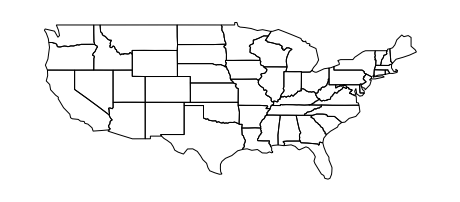

In [9]:
gplt.polyplot(contiguous_usa)

Then plot the locations of each city in the continental US as points (this data is also available through geoplot):

In [10]:
path = gplt.datasets.get_path("usa_cities")
usa_cities = gpd.read_file(path)
usa_cities.head()

,id,POP_2010,ELEV_IN_FT,STATE,geometry
0,53,40888.0,1611.0,ND,POINT (-101.29627 48.23251)
1,101,52838.0,830.0,ND,POINT (-97.03285 47.92526)
2,153,15427.0,1407.0,ND,POINT (-98.70844 46.91054)
3,177,105549.0,902.0,ND,POINT (-96.78980 46.87719)
4,192,17787.0,2411.0,ND,POINT (-102.78962 46.87918)


<AxesSubplot:>

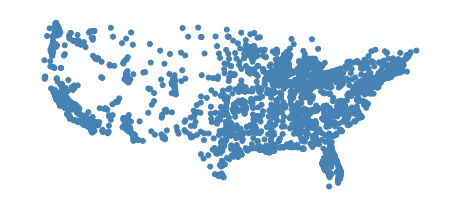

In [11]:
continental_usa_cities = usa_cities.query('STATE not in ["HI", "AK", "PR"]')
gplt.pointplot(continental_usa_cities)

Composing those two, we'll use overplotting to show the cities and states in the continental US. Note how the ax variable for the state polygons provides an axis on which to plot the cities:

<AxesSubplot:>

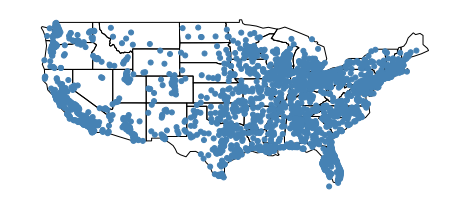

In [12]:
ax = gplt.polyplot(contiguous_usa)
gplt.pointplot(continental_usa_cities, ax=ax)

That looks a bit stretched, so let's adjust the projection to use an Albers equal-area conic projection:

<GeoAxesSubplot:>

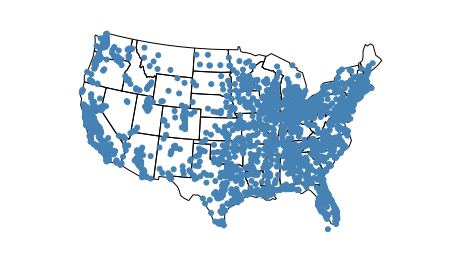

In [13]:
ax = gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea())
gplt.pointplot(continental_usa_cities, ax=ax)

## Representing Data
Now let's compare several different ways to visualize geospatial data. First, we'll change the hue of a city's plotted point based on that city's elevation, and also add a legend for people to decode the meaning of the different hues. The parameter lists start to get long-ish, so we'll split each parameter into a different line:

<GeoAxesSubplot:>

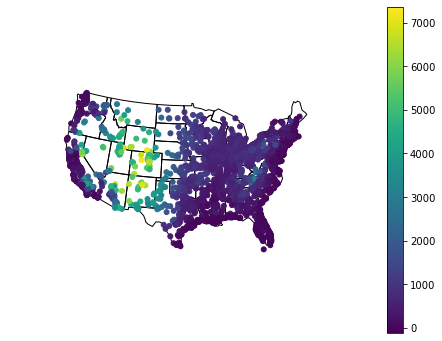

In [14]:
ax = gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea())

gplt.pointplot(
    continental_usa_cities,
    ax=ax,
    hue="ELEV_IN_FT",
    legend=True
)

We can also use the scale of each plotted point to represent another dimension. In this case, the scale of the city points is based on their elevation:

Text(0.5, 1.0, 'Cities in the continental US, by elevation')

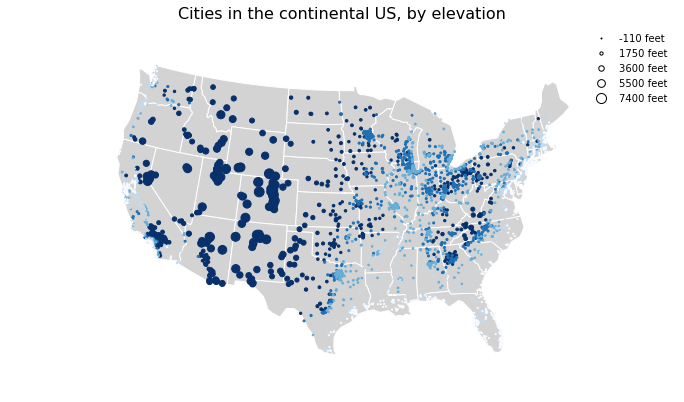

In [15]:

ax = gplt.polyplot(
    contiguous_usa, 
    edgecolor="white",
    facecolor="lightgray",
    figsize=(12, 8),
    projection=gcrs.AlbersEqualArea()
)

gplt.pointplot(
    continental_usa_cities,
    ax=ax,
    hue="ELEV_IN_FT",
    cmap="Blues",
    scheme="quantiles",
    scale="ELEV_IN_FT",
    limits=(1, 10),
    legend=True,
    legend_var="scale",
    legend_kwargs={"frameon": False},
    legend_values=[-110, 1750, 3600, 5500, 7400],
    legend_labels=["-110 feet", "1750 feet", "3600 feet", "5500 feet", "7400 feet"]
)

ax.set_title("Cities in the continental US, by elevation", fontsize=16)

In [16]:
?continental_usa_cities

## TASK 1: Plot the cities in the United States with a point scale for population and a color scale for elevation. 

With a choropleth we use different hues to shade polygons, to represent a dimension of data.

<GeoAxesSubplot:>

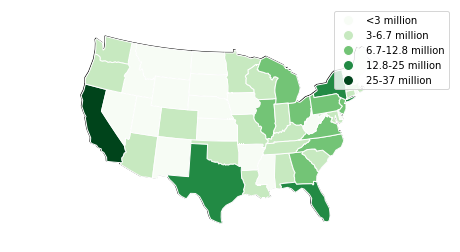

In [17]:
ax = gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea())

gplt.choropleth(
    contiguous_usa,
    hue="population",
    edgecolor="white",
    linewidth=1,
    cmap="Greens",
    legend=True,
    scheme="FisherJenks",
    legend_labels=[
        "<3 million", "3-6.7 million", "6.7-12.8 million",
        "12.8-25 million", "25-37 million"
    ],
    projection=gcrs.AlbersEqualArea(),
    ax=ax
)

A data smoothing technique known as kernel density estimation (KDE) creates contours to represent a dimension of data. In this case, we'll zoom in to view the traffic collisions in the NYC boroughs:

C:\Users\mammo\anaconda3\envs\geoplot_compatible\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\mammo\anaconda3\envs\geoplot_compatible\lib\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


<GeoAxesSubplot:>

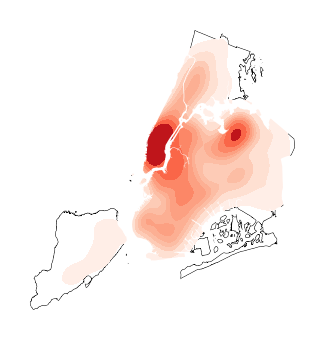

In [18]:
boroughs = gpd.read_file(gplt.datasets.get_path("nyc_boroughs"))
collisions = gpd.read_file(gplt.datasets.get_path("nyc_collision_factors"))

ax = gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea())
gplt.kdeplot(collisions, cmap="Reds", shade=True, clip=boroughs, ax=ax)

Let's zoom out to try KDE on major population centers throughout the US:

C:\Users\mammo\anaconda3\envs\geoplot_compatible\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\mammo\anaconda3\envs\geoplot_compatible\lib\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


<GeoAxesSubplot:>

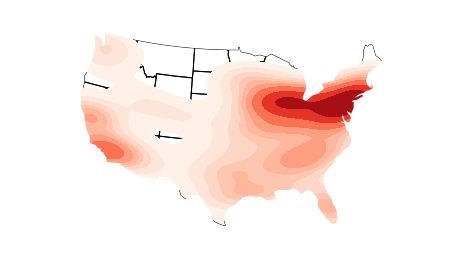

In [19]:
ax = gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea())

gplt.kdeplot(
    continental_usa_cities, 
    cmap="Reds", 
    shade=True, 
    clip=contiguous_usa, 
    ax=ax
)

## TASK 2. Answer: Are we visualizing raw data in the above KDE plots? Why or why not (be specific)?

This next section shows how to work with data associated with areas (polygons). We'll load a dataset about obesity rates by US state:

In [20]:
obesity = pd.read_csv(gplt.datasets.get_path("obesity_by_state"), sep="\t")
obesity.head()

,State,Percent
0,Alabama,32.4
1,Missouri,30.4
2,Alaska,28.4
3,Montana,24.6
4,Arizona,26.8


Convert that into a GeoDataFrame using a join. Note how this adds the required "geometry" column:

In [21]:
geo_obesity = contiguous_usa.set_index("state").join(obesity.set_index("State"))
geo_obesity.head()

,adm1_code,population,geometry,Percent
state,,,,
Minnesota,USA-3514,5303925,"POLYGON ((-89.59941 48.01027, -89.48888 48.013...",25.5
Montana,USA-3515,989415,"POLYGON ((-111.19419 44.56116, -111.29155 44.7...",24.6
North Dakota,USA-3516,672591,"POLYGON ((-96.60136 46.35136, -96.53891 46.199...",31.0
Idaho,USA-3518,1567582,"POLYGON ((-111.04973 44.48816, -111.05025 42.0...",29.6
Washington,USA-3519,6724540,"POLYGON ((-116.99807 46.33017, -116.90653 46.1...",27.2


Now we can use this data to plot a cartogram, which grows or shrinks polygons to represent a dimension of data – in this case, the obesity rates per state:

<GeoAxesSubplot:>

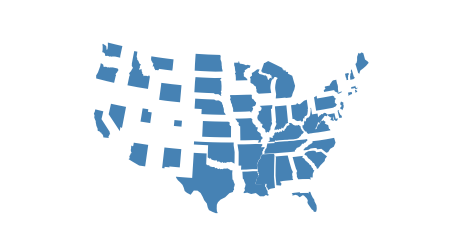

In [22]:
gplt.cartogram(
    geo_obesity,
    scale="Percent",
    projection=gcrs.AlbersEqualArea()
)

One good approach to simplifying data visualization is binning the data into quantiles. These are equal-sized groups, in this case 10 quantiles for elevation:

In [23]:
scheme = mc.Quantiles(continental_usa_cities["ELEV_IN_FT"], k=10)
scheme

Quantiles                 

     Interval        Count
--------------------------
[-112.00,   26.00] |   382
(  26.00,   72.00] |   351
(  72.00,  157.00] |   362
( 157.00,  328.00] |   353
( 328.00,  528.00] |   366
( 528.00,  646.00] |   359
( 646.00,  778.00] |   359
( 778.00,  948.00] |   363
( 948.00, 1310.50] |   359
(1310.50, 7369.00] |   362

Here we've divided the elevations into 10 quantiles with approximately 375 values each. Now let's assign a different hue to each quantile, plus a legend to explain them:

<GeoAxesSubplot:>

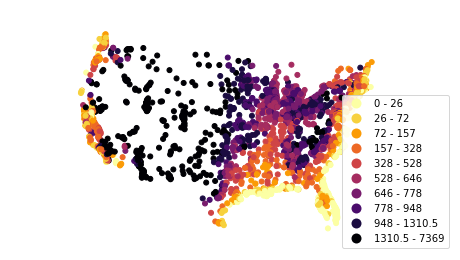

In [24]:
gplt.pointplot(
    continental_usa_cities,
    projection=gcrs.AlbersEqualArea(),
    hue="ELEV_IN_FT",
    scheme=scheme,
    cmap="inferno_r",
    legend=True
)

Note how the colormap was changed to inferno_r. Next, let's add a filter for typical warnings that can be ignored:

In [25]:
import warnings

warnings.filterwarnings("ignore", "GeoSeries.isna", UserWarning)

The next example uses a voronoi diagram, to calculate polygon areas based on a dimension of the data. Each polygon is centered on a generating point, such that every location in the polygon is closer to its generating point than to any other.

In the following example, we'll plot the locations primary schools in Melbourne, Australia, and use a voronoi diagram to show where they are concentrated:

C:\Users\mammo\anaconda3\envs\geoplot_compatible\lib\site-packages\geopandas\geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


Text(0.5, 1.0, 'Primary Schools in Greater Melbourne, 2018')

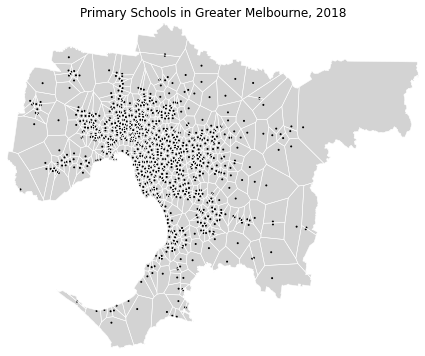

In [26]:
melbourne = gpd.read_file(gplt.datasets.get_path("melbourne"))
df = gpd.read_file(gplt.datasets.get_path("melbourne_schools"))
melbourne_primary_schools = df.query('School_Type == "Primary"')

ax = gplt.voronoi(
    melbourne_primary_schools,
    clip=melbourne,
    linewidth=0.5,
    edgecolor="white",
    projection=gcrs.Mercator()
)

gplt.polyplot(
    melbourne, 
    edgecolor="None", 
    facecolor="lightgray",
    ax=ax
)

gplt.pointplot(
    melbourne_primary_schools,
    color="black",
    ax=ax,
    s=1,
    extent=melbourne.total_bounds
)

plt.title("Primary Schools in Greater Melbourne, 2018")

Let's construct a voronoi diagram for the elevations of US cities. This is a data smoothing technique since the elevations are for points, but we'll "spread" those values across areas:

In [ ]:
proj = gplt.crs.AlbersEqualArea(
    central_longitude=-98,
    central_latitude=39.5
)

ax = gplt.voronoi(
    continental_usa_cities,
    hue="ELEV_IN_FT",
    clip=contiguous_usa,
    projection=proj,
    cmap="Reds",
    legend=True,
    edgecolor="white",
    linewidth=0.01
)

gplt.polyplot(
    contiguous_usa,
    ax=ax,
    extent=contiguous_usa.total_bounds,
    edgecolor="black",
    linewidth=1,
    zorder=1
)

## TASK 3: Fix this error message so you can plot your data.

## LEARN SO MUCH MORE:
"Real Python" data visualization tutorials on all things data visualization using multiple packages: https://realpython.com/tutorials/data-viz/

To learn more about geospatial plotting packages:
https://towardsdatascience.com/best-libraries-for-geospatial-data-visualisation-in-python-d23834173b35

"Scientist's Guide to Plotting Data in Python Textbook"
https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/